In [3]:
import numpy as np
import pandas as pd
import ipaddress
import netaddr
import matplotlib.pyplot as plt
from data_collection.parse_pcap import pcap_to_pandas, pcap_to_dict
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Linear & Logistic Regression

Today we start using artificial intelligence to make inferences about IoT device and Internet browsing traffic. The first techniques we will be using are linear and logistic regression. 

### Linear Regression

Suppose we have a list of 2D points, where the $x$ value of each point is the number of hours per day a different IoT device is on, and the $y$ value of the point is the cost of energy consumed by the device (\$ per year).

In [4]:
points = np.asarray([(1,20), (5,40), (3,70), (4,50), (1.5,40), (2,30), (6,80), (7,70), (8,90), (10,80)])

We can plot these points on the $xy$ axis.

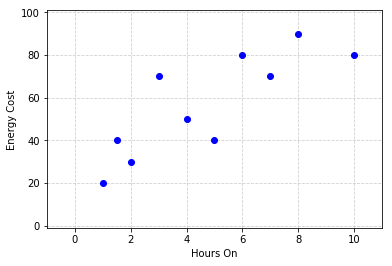

In [5]:
plt.plot(points[:,0], points[:,1], '.', color='blue', markersize=12)
plt.grid(linestyle='--', alpha=0.6)
plt.xlabel('Hours On')
plt.ylabel('Energy Cost')
plt.xlim((-1,11))
plt.ylim((-1,101))
plt.show()

Now suppose that we want to draw a line that goes through the middle of the collection of points with minimal distance between the line and each point along the y-axis. The equation for a line is $y=mx+b$, where $m$ is the slope of the line and $b$ is the $y$-intercept. The following code plots a line in addition to the points from before. Change the values of $m$ and $b$ to find a line with the smallest total distance to the points. When you've found good values for $m$ and $b$, raise your hand.

Total Distance: 113.5000


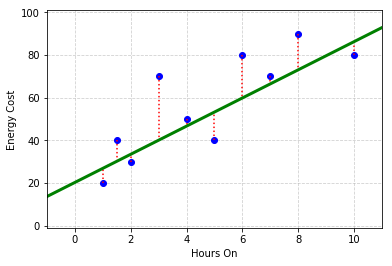

In [6]:
m = 6.6 # change 
b = 20.3 # change

# Calculate the distances from the line to the points
points_x, points_y = points[:,0], points[:,1] # x and y values of the points
line_y = m * points_x + b                     # y values of the line at the x values of the points
distances = np.sqrt((points_y - line_y)**2)   # distances from y values of the points to y values of the line
total_distance = np.sum(distances)            # sum of the distances
print("Total Distance: {:.4f}".format(total_distance))

# Plot the line and points
plt.plot(points_x, points_y, '.', color='blue', markersize=12)
for px, py, ly in zip(points_x, points_y, line_y):
    plt.plot([px, px], [py, ly], ':', color='red', linewidth=1.5)
plt.plot([-2, 12], np.array([-2,12])*m + b, '-', color='green', linewidth=3)
plt.grid(linestyle='--', alpha=0.6)
plt.xlim((-1, 11))
plt.ylim((-1, 101))
plt.xlabel('Hours On')
plt.ylabel('Energy Cost')
plt.show()

Congratulations! You've done linear regression! 

Fortunately, there are Python functions which will find the best line for us, so we don't have to do it manually.
The following code plots the points, your line in green, and the optimal line determined by the Python LinearRegression function in red. 

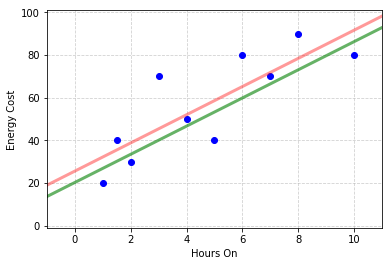

In [7]:
# Fit the linear regression
linear_regression = linear_model.LinearRegression()
linear_regression.fit(points_x.reshape(-1,1), points_y)
best_line_ys = linear_regression.predict(np.array([-2,12]).reshape(-1,1))

# Plot the results along with the points and previous line
plt.plot(points_x, points_y, '.', color='blue', markersize=12)
plt.plot([-2, 12], np.array([-2,12])*m + b, '-', color='green', linewidth=3, alpha=0.6)
plt.plot([-2, 12], best_line_ys, color='red', alpha=0.4, linewidth=3)
plt.grid(linestyle='--', alpha=0.6)
plt.xlim((-1, 11))
plt.ylim((-1, 101))
plt.xlabel('Hours On')
plt.ylabel('Energy Cost')
plt.show()

So why is this useful? Suppose someone is thinking about buying a new device, which will be on for 9 hours a day, and wants to know how much the energy to run the device will cost. We can use the $y$-value of the line at $x = 9$ to predict the cost. We could repeat this prediction for any new value of $x$ and obtain a reasonable energy cost prediction.

In [8]:
hours_on = 9
predicted_cost = linear_regression.predict([[hours_on]])
print("Predicted energy cost of device with {} hours on per day: {}".format(hours_on, predicted_cost[0]))

Predicted energy cost of device with 9 hours on per day: 85.06976744186045


Of course, there are many factors which affect energy consumption apart from the length of time a device is powered on. Raise your hand if you can think of some reasons why this predicted cost might not be accurate.

However, given that the only information we have about these hypothetical devices are hours on, the linear regression line gives us the highest probability prediction possible assuming a linear relationship between hours on and energy cost. 

## Logistic Regression

Logistic Regression is very similar to linear regression, except all of the points can only have $y$-values of $1$ or $0$. This is useful if we want to predict whether something is or isn't part of a particular class. Instead of fitting a line (as in linear regression), logistic regression involves fitting a probability curve.

For example, using our device traffic, let's see whether we can predict a DNS packet is request or response from its length. 

First, let's import the data, extract only the DNS packets, and view the first few packets.

In [9]:
pcap = pcap_to_pandas('example_pcaps/google_home.pcap') # this can take a few minutes
dns_packets = pcap.loc[pcap['is_dns'] == True];
dns_packets.head(n=5)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
16,2017-12-07 15:48:44.399009,b'clients1.google.com.',None,8.8.8.8,1.347441e+08,172.24.1.51,2.887254e+09,True,79,b8:27:eb:2d:24:15,202481588839445,a4:77:33:2f:e0:6e,180831866839150,53.0,43659.0,UDP,1.512680e+09,3.242926
17,2017-12-07 15:48:44.419893,b'pool.ntp.org.',None,8.8.8.8,1.347441e+08,172.24.1.51,2.887254e+09,True,72,b8:27:eb:2d:24:15,202481588839445,a4:77:33:2f:e0:6e,180831866839150,53.0,37402.0,UDP,1.512680e+09,3.263810
18,2017-12-07 15:48:44.423984,b'clients1.google.com.',b'clients1.google.com.',172.24.1.51,2.887254e+09,8.8.8.8,1.347441e+08,True,119,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,43659.0,53.0,UDP,1.512680e+09,3.267901
23,2017-12-07 15:48:44.458457,b'pool.ntp.org.',b'pool.ntp.org.',172.24.1.51,2.887254e+09,8.8.8.8,1.347441e+08,True,136,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,37402.0,53.0,UDP,1.512680e+09,3.302374
27,2017-12-07 15:48:44.480588,b'_googlecast._tcp.local.',None,224.0.0.251,3.758097e+09,172.24.1.51,2.887254e+09,True,82,01:00:5e:00:00:fb,1101088686331,a4:77:33:2f:e0:6e,180831866839150,5353.0,5353.0,UDP,1.512680e+09,3.324505


Each row in the printed data is a packet and each column is a feature of the packet.

Next let's divide the DNS packets into requests and repsonses, and convert them into points where the $x$-value is the length of the packet and $y$-value is $1$ for requests and $0$ for responses

In [10]:
y = dns_packets.apply(lambda row: 1 if row['dns_resp'] == None else 0, axis=1).values
x = dns_packets['length'].values.reshape(-1, 1)
x_req = dns_packets.loc[dns_packets['dns_resp'].isnull()]['length'].values.reshape(-1, 1)
x_res = dns_packets.loc[dns_packets['dns_resp'].notnull()]['length'].values.reshape(-1, 1)

We can plot these points with the requests in red and the responses in blue. 

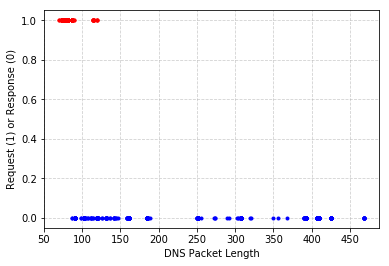

In [11]:
plt.plot(x_req, np.ones(len(x_req)), '.', color='red')
plt.plot(x_res, np.zeros(len(x_res)), '.', color='blue')
plt.ylabel("Request (1) or Response (0)")
plt.xlabel("DNS Packet Length")
plt.grid(linestyle='--', alpha=0.6)
plt.show()

What does this tell us about the difference in packet length between DNS request packets and DNS response packets? How will this make it possible to predict the type of new DNS packets? Raise your hand with answers to these questions.

Now we can fit a logistic probability curve to these points. and plot the result.

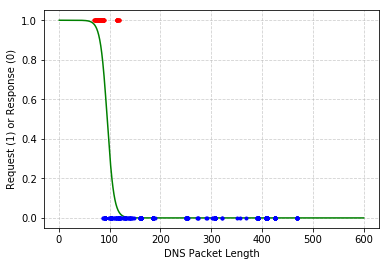

In [12]:
# Fit the logistic curve (C is a regularization parameter, feel free to play with it!)
logistic_regression = linear_model.LogisticRegression(C=100);
logistic_regression.fit(x, y);

# Plot data
z = np.arange(1, 600, 0.5).reshape(-1, 1);
plt.plot(z, logistic_regression.predict_proba(z)[:, 1], color='green');
plt.plot(x_req, np.ones(len(x_req)), '.', color='red')
plt.plot(x_res, np.zeros(len(x_res)), '.', color='blue')
plt.ylabel("Request (1) or Response (0)")
plt.xlabel("DNS Packet Length")
plt.grid(linestyle='--', alpha=0.6)
plt.show()

Let's load some new data from a different device and see how well this logistic regression curve can be used to predict DNS requests versus responses for new packets. 

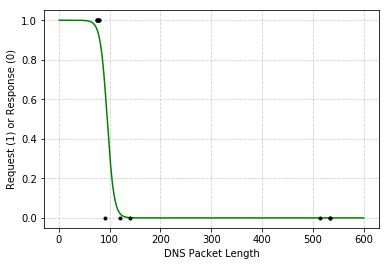

In [13]:
# Load a test data file
pcap_test = pcap_to_pandas('example_pcaps/tplink_switch.pcap');
test_dns_packets = pcap_test.loc[pcap_test['is_dns']];
y = test_dns_packets.apply(lambda row: 1 if row['dns_resp'] == None else 0, axis=1).values
x = test_dns_packets['length'].values.reshape(-1, 1)

# Plot with logistic curve
z = np.arange(1, 600, 0.5).reshape(-1, 1);
plt.plot(z, logistic_regression.predict_proba(z)[:, 1], color='green');
plt.plot(x, y, '.', color='black')
plt.ylabel("Request (1) or Response (0)")
plt.xlabel("DNS Packet Length")
plt.grid(linestyle='--', alpha=0.6)
plt.show()

In [25]:
# Calculate prediction accuracy
correct_y = test_dns_packets.apply(lambda row: 1 if row['dns_resp'] == None else 0, axis=1).values
predicted_y = test_dns_packets.apply(lambda row: logistic_regression.predict(row['length'])[0], axis=1)
num_correct_predictions = sum(correct_y == predicted_y)
accuracy = num_correct_predictions / len(test_dns_packets)
print('{} of {} packets correctly predicted as DNS requests or responses for an accuracy of {:.2f}%'.format(
    num_correct_predictions, len(test_dns_packets), accuracy*100))

11 of 12 packets correctly predicted as DNS requests or responses for an accuracy of 91.67%


## Futher Applications

### Linear vs. Logistic Regression
Try modifying the example code above for the DNS classifier to use a linear regression. Note that the `predict` method for the linear model outputs a decimal, not a label. To handle this case, simply label an input as `1` if the model outputs a value higher than `0.5` (or some other threshold of your choosing), and `0` otherwise.

Does this method work as well as the logistic regression? Why or why not? What patterns in the data would the logistic regression have trouble modelling?

### Classifying Packet Protocol

Repeat the above experiments, but this time try to predict the *protocol* of the packet. A good feature to use for this task is, again, the packet length. Can you find any other features in the dataset that work well?